In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
data=pd.read_csv('data.csv')

In [3]:
data.head(2)

,article_id,article_topic,article_content
0,93205794,Internasional,Kepolisian Inggris tengah memburu pelaku yang...
1,93186698,Ekonomi,Seluruh layanan transaksi di jalan tol akan m...


In [4]:
data.shape

(10000, 3)

In [5]:
original_data=data

In [6]:
data['article_topic'].value_counts()

Ekonomi          1762
Haji             1497
Hiburan          1466
Sepak Bola       1184
Internasional     741
Lifestyle         572
Teknologi         571
Sports            435
Bojonegoro        260
Kesehatan         195
Sains             174
Otomotif          174
Health            131
Politik           104
Hukum              85
Personal           81
Travel             76
Sejarah            70
Pendidikan         70
K-Pop              61
Obat-obatan        58
Horor              50
KPK                37
Regional           35
MotoGP             35
Bisnis             25
Pilgub Jatim       25
Keuangan           14
Jakarta            12
Name: article_topic, dtype: int64

###### check null

In [7]:
data.isnull().sum()

article_id          0
article_topic       0
article_content    36
dtype: int64

In [8]:
data=data.dropna()

In [9]:
data.isnull().sum()

article_id         0
article_topic      0
article_content    0
dtype: int64

#### Class Visualization

In [10]:
import matplotlib.pyplot as plt

In [11]:
import seaborn as sns
sns.set(style="whitegrid")

In [12]:
total_categories=data['article_topic'].value_counts()
categories=data['article_topic'].unique()
percentage_in_dataset=[round(num/data.shape[0]*100,2) for num in total_categories]

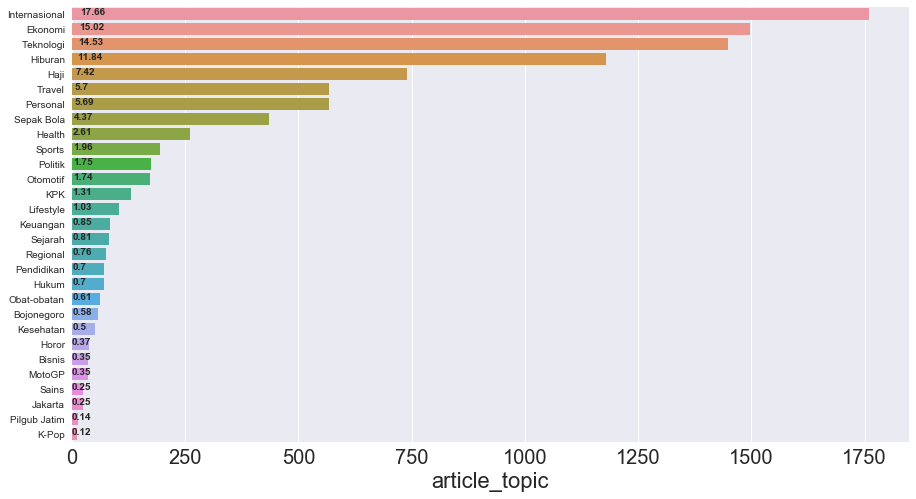

In [13]:
y_pos=len(categories)
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax= sns.barplot(total_categories,categories,orient='h')
plt.setp(ax.get_yticklabels(), fontsize=10)
for i, v in enumerate(percentage_in_dataset):
    ax.text(v,i, str(v),fontweight='bold',fontsize=10)
plt.show()

In [14]:
document_lengths = np.array(list(map(len, data.article_content.str.split(' '))))

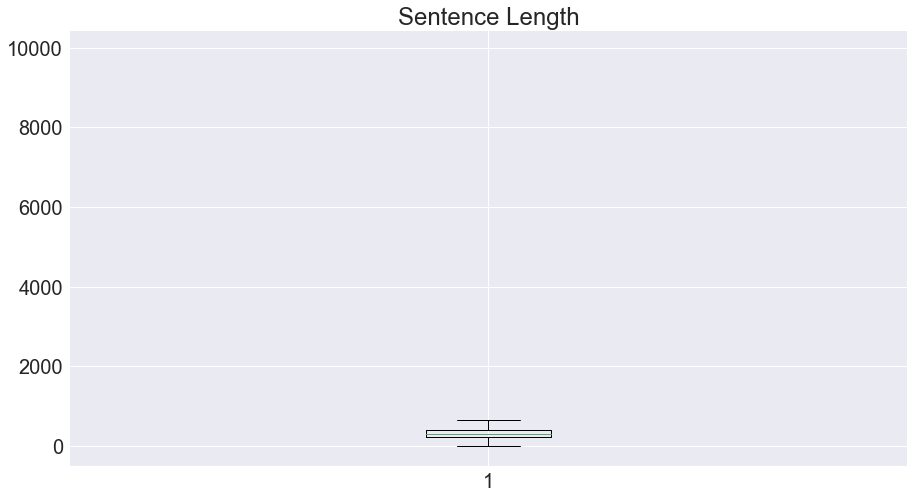

In [15]:
plt.figure(figsize=(15,8))
plt.title('Sentence Length')
plt.boxplot(document_lengths)
plt.show()

In [16]:
data['category_id'] = data['article_topic'].factorize()[0]

C:\Users\reza.sugiarto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
category_id_df = data[['article_topic', 'category_id']].drop_duplicates().sort_values('category_id')

In [18]:
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'article_topic']].values)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2))
features = tfidf.fit_transform(data.article_content).toarray()
labels = data.category_id

In [20]:
from sklearn.feature_selection import chi2

N = 3
for category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(category))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Bisnis':
  . Most correlated unigrams:
       . steak
       . wiryono
       . lucy
  . Most correlated bigrams:
       . banyak bisnis
       . equity world
       . kuningan city
# 'Bojonegoro':
  . Most correlated unigrams:
       . v2
       . blokbojonegoro
       . bojonegoro
  . Most correlated bigrams:
       . com v2
       . kabupaten bojonegoro
       . blokbojonegoro com
# 'Ekonomi':
  . Most correlated unigrams:
       . rp
       . bank
       . saham
  . Most correlated bigrams:
       . sri mulyani
       . dolar as
       . rp 13
# 'Haji':
  . Most correlated unigrams:
       . jamaah
       . jemaah
       . haji
  . Most correlated bigrams:
       . arab saudi
       . haji indonesia
       . jemaah haji
# 'Health':
  . Most correlated unigrams:
       . obat
       . herbal
       . gamat
  . Most correlated bigrams:
       . obat herbal
       . jelly gamat
       . gamat emas
# 'Hiburan':
  . Most correlated unigrams:
       . enggak
       . film
       . aku

In [21]:
from sklearn.manifold import TSNE

In [22]:
# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)

In [23]:
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])

C:\Users\reza.sugiarto\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
No handles with labels found to put in legend.


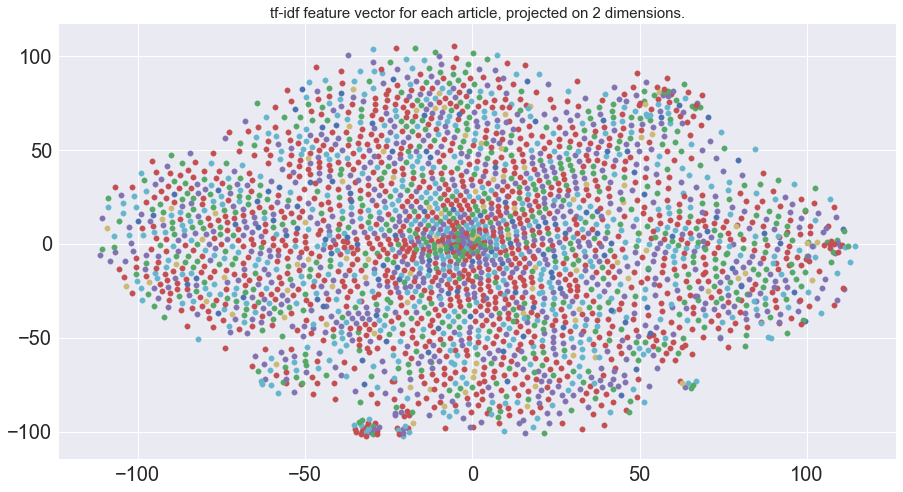

In [24]:
plt.figure(figsize=(15,8))
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

##### Preprocess text

In [25]:
#Remove link
def remove_link(text):
    return re.sub(r'http[s]?://\S+','',text)

remove_link('https://youtu.be/Z-Nv2rLbkWQ haha not today')

' haha not today'

In [26]:
#Remove punctuation
import string
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

remove_punctuation('@can you! pass this?> ....... ofc^@#*&^$*')

'can you pass this  ofc'

In [27]:
#remove newline
def remove_newline(text):
    return re.sub(r'\r?\n|\r','',text)

remove_newline("""hehe
 enter""")

'hehe enter'

In [28]:
#remove emoticon, because why?
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

deEmojify('Pokonya bintang 5 untuk toko iniii👍')

'Pokonya bintang 5 untuk toko iniii'

In [29]:
from bs4 import BeautifulSoup

In [30]:
#Remove html
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

strip_html('<a> hhehe <div>')

' hhehe '

In [31]:
#Remove number
def remove_number(text):
    return re.sub(r'\d*','',text)

remove_number('9238493jidfjdkjfi2u343u4')

'jidfjdkjfiuu'

In [32]:
def text_processing(text):
    text=text.lower()
    text=remove_link(text)
    text=strip_html(text)
    text=remove_newline(text)
    text=deEmojify(text)
    text=remove_punctuation(text)
    text=remove_number(text)
    return text

In [33]:
data['preprocess_text']=data['article_content'].apply(text_processing)

C:\Users\reza.sugiarto\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'  .'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\reza.sugiarto\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'  .'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\reza.sugiarto\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'  .'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\reza.sugiarto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [34]:
data.head(5)

,article_id,article_topic,article_content,category_id,preprocess_text
0,93205794,Internasional,Kepolisian Inggris tengah memburu pelaku yang...,0,kepolisian inggris tengah memburu pelaku yang...
1,93186698,Ekonomi,Seluruh layanan transaksi di jalan tol akan m...,1,seluruh layanan transaksi di jalan tol akan m...
2,93191463,Teknologi,"\nHari ini, Rabu (23/8), ternyata menjadi har...",2,hari ini rabu ternyata menjadi hari yang spe...
3,93219292,Ekonomi,Saat ini Indonesia hanya memiliki cadangan ba...,1,saat ini indonesia hanya memiliki cadangan ba...
4,343106,Hiburan,"Hari ini, Selasa (1/8), pedangdut Ridho Rhoma...",3,hari ini selasa pedangdut ridho rhoma kembal...


In [35]:
from collections import Counter 

In [36]:
Counter(" ".join(data['preprocess_text']).split()).most_common(100)

[('yang', 93792),
 ('di', 73433),
 ('dan', 67492),
 ('ini', 39787),
 ('dengan', 36230),
 ('untuk', 34503),
 ('dari', 30406),
 ('itu', 27505),
 ('pada', 25245),
 ('dalam', 21202),
 ('akan', 19895),
 ('tidak', 19211),
 ('juga', 18573),
 ('ke', 18205),
 ('tahun', 16083),
 ('bisa', 15854),
 ('karena', 15271),
 ('ada', 14450),
 ('mereka', 13660),
 ('tersebut', 12765),
 ('sudah', 12188),
 ('indonesia', 12113),
 ('saat', 11606),
 ('menjadi', 11527),
 ('oleh', 11457),
 ('adalah', 10906),
 ('haji', 10613),
 ('atau', 10185),
 ('lebih', 10171),
 ('satu', 8974),
 ('tak', 8890),
 ('saya', 8798),
 ('sebagai', 8569),
 ('seperti', 7628),
 ('kita', 7553),
 ('hanya', 7395),
 ('telah', 7345),
 ('dia', 7312),
 ('orang', 7172),
 ('jemaah', 7030),
 ('masih', 7022),
 ('harus', 6942),
 ('kami', 6675),
 ('banyak', 6447),
 ('pun', 6363),
 ('rp', 6253),
 ('ia', 6166),
 ('namun', 6027),
 ('hari', 6025),
 ('para', 5904),
 ('hal', 5782),
 ('lalu', 5712),
 ('kepada', 5697),
 ('bahwa', 5649),
 ('dua', 5607),
 ('setel

#### Remove Stopword

In [37]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [38]:
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

In [39]:
kalimat = 'Dengan Menggunakan Python dan Library Sastrawi saya dapat melakukan proses Stopword Removal'
stopword.remove(kalimat)

'Dengan Menggunakan Python Library Sastrawi dapat melakukan proses Stopword Removal'

In [40]:
def remove_stopword(text):
    return stopword.remove(text)

In [41]:
data['preprocess_stopword_text']=data['preprocess_text'].apply(remove_stopword)

C:\Users\reza.sugiarto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [42]:
data.head(2)

,article_id,article_topic,article_content,category_id,preprocess_text,preprocess_stopword_text
0,93205794,Internasional,Kepolisian Inggris tengah memburu pelaku yang...,0,kepolisian inggris tengah memburu pelaku yang...,kepolisian inggris tengah memburu pelaku mele...
1,93186698,Ekonomi,Seluruh layanan transaksi di jalan tol akan m...,1,seluruh layanan transaksi di jalan tol akan m...,seluruh layanan transaksi jalan tol mulai men...


In [43]:
Counter(" ".join(data['preprocess_stopword_text']).split()).most_common(100)

[('tahun', 16083),
 ('tersebut', 12765),
 ('indonesia', 12113),
 ('menjadi', 11527),
 ('haji', 10613),
 ('lebih', 10171),
 ('satu', 8974),
 ('tak', 8890),
 ('tidak', 7196),
 ('yang', 7192),
 ('orang', 7172),
 ('jemaah', 7030),
 ('akan', 6868),
 ('bisa', 6523),
 ('banyak', 6447),
 ('rp', 6253),
 ('itu', 6105),
 ('juga', 6059),
 ('hari', 6025),
 ('lalu', 5712),
 ('ini', 5599),
 ('ada', 5539),
 ('membuat', 5479),
 ('jadi', 5473),
 ('beberapa', 5456),
 ('memiliki', 5394),
 ('pemain', 5379),
 ('kata', 5243),
 ('hingga', 5158),
 ('baru', 5154),
 ('di', 4928),
 ('salah', 4884),
 ('melakukan', 4880),
 ('wafat', 4738),
 ('sama', 4707),
 ('sangat', 4633),
 ('waktu', 4572),
 ('usia', 4491),
 ('jakarta', 4366),
 ('baik', 4349),
 ('pertama', 4322),
 ('kalau', 4310),
 ('sudah', 4251),
 ('merupakan', 4112),
 ('kali', 4067),
 ('memang', 4040),
 ('gol', 3949),
 ('dilakukan', 3937),
 ('dunia', 3894),
 ('mengatakan', 3893),
 ('kedua', 3863),
 ('agustus', 3857),
 ('atas', 3852),
 ('selama', 3795),
 ('besa

In [44]:
tfidf_processing = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2))
features_processing = tfidf_processing.fit_transform(data.preprocess_stopword_text).toarray()
labels = data.category_id

In [45]:
N = 3
for category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features_processing, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_processing.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(category))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Bisnis':
  . Most correlated unigrams:
       . steak
       . wiryono
       . lucy
  . Most correlated bigrams:
       . equity world
       . peluang usaha
       . kuningan city
# 'Bojonegoro':
  . Most correlated unigrams:
       . blokbojonegorocom
       . reporter
       . bojonegoro
  . Most correlated bigrams:
       . reporter sutopoblokbojonegorocom
       . reporter yazidblokbojonegorocom
       . kabupaten bojonegoro
# 'Ekonomi':
  . Most correlated unigrams:
       . rp
       . bank
       . saham
  . Most correlated bigrams:
       . dolar as
       . sri mulyani
       . rp triliun
# 'Haji':
  . Most correlated unigrams:
       . jamaah
       . jemaah
       . haji
  . Most correlated bigrams:
       . arab saudi
       . haji indonesia
       . jemaah haji
# 'Health':
  . Most correlated unigrams:
       . obat
       . herbal
       . gamat
  . Most correlated bigrams:
       . obat herbal
       . jelly gamat
       . gamat emas
# 'Hiburan':
  . Most correlated

#### Split train and test

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    data['preprocess_stopword_text'], data['category_id'], data.index, test_size=0.33, random_state=0)

## Tf-Idf

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [50]:
tfidf_train = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2))
X_train_tfidf = tfidf_train.fit_transform(X_train).toarray()

In [51]:
X_test_tfidf = tfidf_train.transform(X_test).toarray()

### Multinomial Naive Bayes

In [52]:
from sklearn.naive_bayes import MultinomialNB

In [53]:
gnb = MultinomialNB()

In [54]:
gnb.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [55]:
y_pred = gnb.predict(X_test_tfidf)

In [56]:
y_proba = gnb.predict_proba(X_test_tfidf)[:,1]

In [57]:
from sklearn.metrics import accuracy_score

In [58]:
accuracy_score(y_test, y_pred)

0.6755852842809364

In [59]:
from sklearn.metrics import classification_report

In [60]:
print(classification_report(y_test, y_pred,target_names=category_id_df.article_topic))

               precision    recall  f1-score   support

Internasional       0.91      0.58      0.71       239
      Ekonomi       0.58      0.98      0.73       585
    Teknologi       1.00      0.39      0.56       179
      Hiburan       0.57      0.99      0.72       474
         Haji       0.87      0.96      0.92       481
       Travel       0.00      0.00      0.00        23
     Personal       0.00      0.00      0.00        28
   Sepak Bola       0.73      0.99      0.84       401
       Health       0.00      0.00      0.00        39
       Sports       0.94      0.11      0.19       152
      Politik       0.00      0.00      0.00        43
     Otomotif       1.00      0.17      0.29        65
          KPK       1.00      0.44      0.62         9
    Lifestyle       0.71      0.28      0.40       203
     Keuangan       0.00      0.00      0.00         6
      Sejarah       0.00      0.00      0.00        22
     Regional       0.00      0.00      0.00        13
   Pendid

C:\Users\reza.sugiarto\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Text(0.5,47,'Predicted')

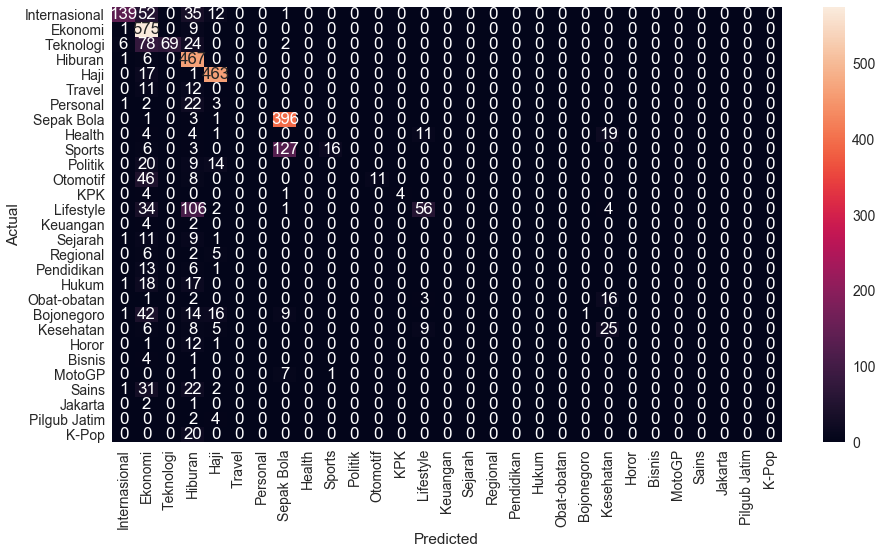

In [62]:
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(15,8))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.article_topic.values, yticklabels=category_id_df.article_topic.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [63]:
from sklearn.linear_model import LogisticRegression

In [64]:
lr=LogisticRegression(random_state=0)

In [65]:
lr.fit(X_train_tfidf,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [66]:
y_pred = lr.predict(X_test_tfidf)

In [67]:
accuracy_score(y_test,y_pred)

0.8303435694740042

In [68]:
print(classification_report(y_test, y_pred,target_names=category_id_df.article_topic))

               precision    recall  f1-score   support

Internasional       0.78      0.87      0.83       239
      Ekonomi       0.78      0.97      0.87       585
    Teknologi       0.94      0.79      0.86       179
      Hiburan       0.77      0.98      0.87       474
         Haji       0.98      0.99      0.98       481
       Travel       0.00      0.00      0.00        23
     Personal       0.00      0.00      0.00        28
   Sepak Bola       0.81      0.99      0.89       401
       Health       0.76      0.49      0.59        39
       Sports       0.86      0.41      0.55       152
      Politik       1.00      0.12      0.21        43
     Otomotif       1.00      0.63      0.77        65
          KPK       1.00      0.78      0.88         9
    Lifestyle       0.84      0.87      0.86       203
     Keuangan       0.00      0.00      0.00         6
      Sejarah       0.00      0.00      0.00        22
     Regional       0.00      0.00      0.00        13
   Pendid

C:\Users\reza.sugiarto\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0.5,47,'Predicted')

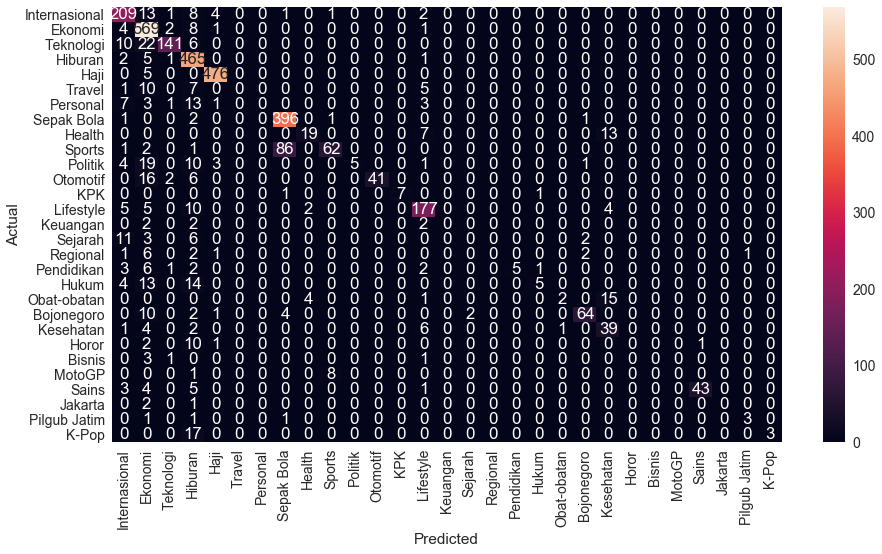

In [69]:
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(15,8))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.article_topic.values, yticklabels=category_id_df.article_topic.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [70]:
from sklearn.linear_model import SGDClassifier

In [71]:
sgd=SGDClassifier(loss='hinge', penalty='l2', random_state=0)

In [72]:
sgd.fit(X_train_tfidf,y_train)

C:\Users\reza.sugiarto\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [73]:
y_pred = sgd.predict(X_test_tfidf)

In [74]:
accuracy_score(y_test,y_pred)

0.883855275159623

In [75]:
print(classification_report(y_test, y_pred,target_names=category_id_df.article_topic))

               precision    recall  f1-score   support

Internasional       0.91      0.85      0.88       239
      Ekonomi       0.90      0.98      0.94       585
    Teknologi       0.95      0.86      0.90       179
      Hiburan       0.88      0.98      0.92       474
         Haji       0.98      0.99      0.99       481
       Travel       0.69      0.78      0.73        23
     Personal       0.69      0.32      0.44        28
   Sepak Bola       0.82      0.99      0.90       401
       Health       0.76      0.72      0.74        39
       Sports       0.91      0.39      0.54       152
      Politik       0.84      0.49      0.62        43
     Otomotif       0.97      0.89      0.93        65
          KPK       0.88      0.78      0.82         9
    Lifestyle       0.84      0.91      0.87       203
     Keuangan       0.00      0.00      0.00         6
      Sejarah       0.71      0.55      0.62        22
     Regional       1.00      0.08      0.14        13
   Pendid

C:\Users\reza.sugiarto\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0.5,47,'Predicted')

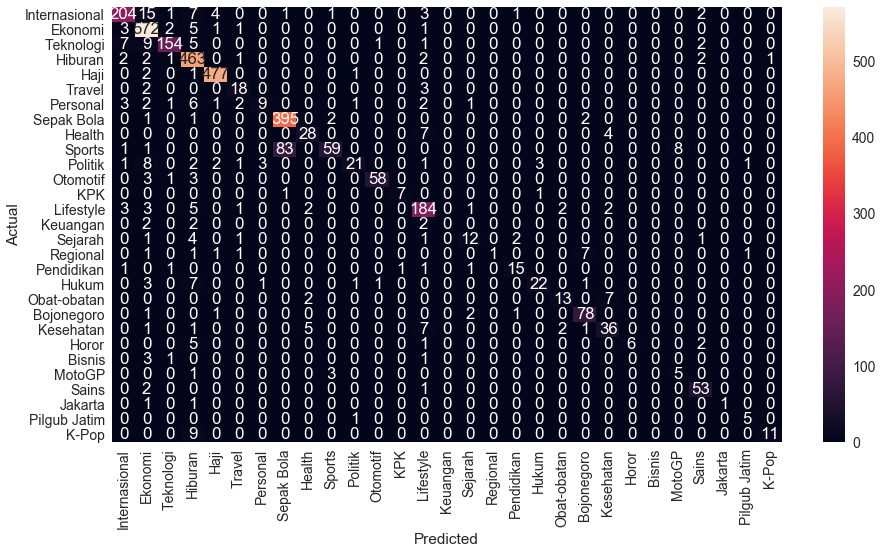

In [76]:
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(15,8))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.article_topic.values, yticklabels=category_id_df.article_topic.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [77]:
import pickle

In [79]:
pickle.dump(sgd, open('model_sgd.pickle', 'wb'))